# DATA 100 Final Project
### Dataset: COVID-19
### Group members: 
Patcharaporn Maneerat pmaneera31@berkeley.edu   
Yuexin Li yuexinli@berkeley.edu  
Danqing Wang danqingwang@berkeley.edu 

In [1]:
# Import libraries 

! pip install geopandas 
! pip install descartes

import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## The Data

There are two major datasets used in this study. One is from CSSE(Center For Systems Science and Engineering at JHU) while the other is from the Department of Statistics in UC Berkeley. 
The first set of data includes the US time series of COVID-19 confirmed and death cases. We used the US time series up 
to May 7th, 2020, which includes more data than the provided version. The second dataset is the population database of individual 
counties. This file includes much information, such as population, percentages of smokers and diabetes, numbers of hospitals, ICU 
beds, dates of the orders announced after the first COVID-19 confirmed case, etc. Note that the data we used are more updated versions
of the provided dataset. The sources of datasets used in this study can be found in the link below:

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-30-2020.csv
https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/county_data_abridged.csv


## Load Data Files

In [2]:
# Timeseries of the confirmed and deaths cases in US counties
timeConfirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
timeDeath = pd.read_csv("time_series_covid19_deaths_US.csv")
# General information for each county
Counties = pd.read_csv("county_data_abridged.csv")
# COVID-19 information for each states (include total number of confirmed, recovered, etc)
statesData = pd.read_csv('4.30states_withstatenames.csv')

## Structure of the Notebook

In this project, we aim to examine and analyze the COVID-19 confirmed and death datasets. We would like to address two main questions.   
**First**, we investigate the factors affecting how fast the virus spreads in different US counties.  
**Secondly**, we will utilize the historical trends of confirmed and dead time series, particularly in NY to build up 
a 7-day forcasting model. 

The notebook will be structured as followed:  
**(1)** First, we clean up and prepare the data for further analysis    
**(2)** Then, we perform visulization to get an overview of the data    
**(3)** Feature enginering and analysis for Question 1   
**(4)** Feature enginering and analysis for Question 2

## Part 1 Data Cleaning

This study only focus on states and counties of the US. Therefore, we drop US territory and cruise data from the original dataframe.

In [3]:
# Cleaning time-series data
# Drop US territories &  cruises, only focus on states in the US
territory = ['Northern Mariana Islands','Virgin Islands','American Samoa','Guam','Grand Princess','Diamond Princess','Puerto Rico']
timeConfirmed_org = timeConfirmed[timeConfirmed["Province_State"].isin(territory) == False].reset_index()
timeDeath_org  = timeDeath[timeDeath["Province_State"].isin(territory) == False].reset_index()

# Cleaning US county data, only focus on states in the US
Counties = Counties[Counties["countyFIPS"].isin(["City1","City2"]) == False]
Counties = Counties[Counties["StateName"].isin(["AS","GU","PR","VI","MP"]) == False]
counties = Counties.copy()

# Cleaning state data, only keep statistics within the US 
USstates = statesData[statesData['Country_Region'] == 'US']
USstates = USstates.dropna(subset=['StateName'])
USstates = USstates.reset_index().drop('index', axis = 1)

# Join the time-series dataframe with state name
timeConfirmed = timeConfirmed_org.merge(USstates[['StateName', 'Province_State']], on ='Province_State')
timeDeath = timeDeath_org.merge(USstates[['StateName', 'Province_State']], on ='Province_State')


## Part 2 Data Visualization

### 2.1 Timeseries of the cumulative confirmed and death cases of all states

In [4]:
## Plot time series data
def plot_time_series(dataframe, ylabel, title):
    tmp = dataframe.dropna(subset =['StateName'])
    tmp = tmp.groupby('StateName').sum()
    tmp = tmp.rename(lambda x:x[:len(x)-3], axis='columns')
    # sort states names by the cumulative # of cases
    tmp = tmp.sort_values(by='5/7',ascending=False)
    tmp = tmp.iloc[:,7:].T

    plt.figure(figsize=(10,4))
    sns.lineplot(data = tmp.iloc[52:],palette="gist_rainbow", linewidth=1.5, dashes=False, sort=False)
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(fontsize=5,  labelspacing = None, ncol = 2)

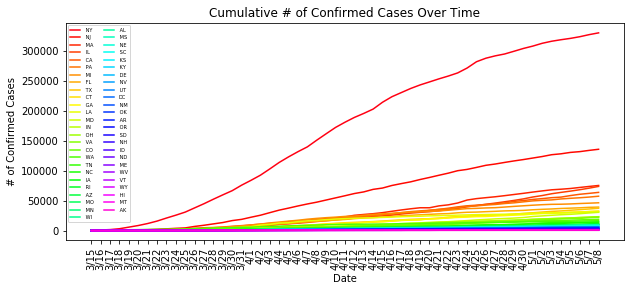

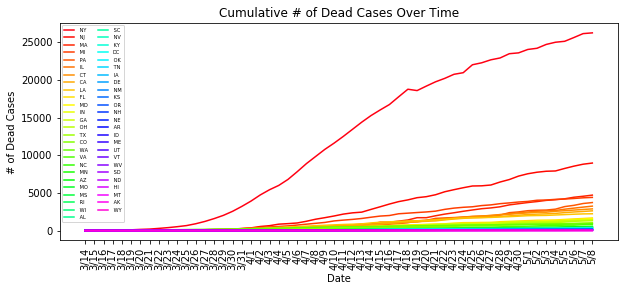

In [5]:
plot_time_series(timeConfirmed, '# of Confirmed Cases', 'Cumulative # of Confirmed Cases Over Time')
plot_time_series(timeDeath, '# of Dead Cases', 'Cumulative # of Dead Cases Over Time')

### 2.2 Map view of the comfirmed cases acorss the US

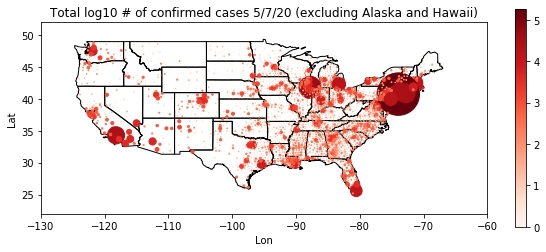

In [6]:
## Plot the cumulative confirmed cases in US 
timeConfirmed = timeConfirmed[timeConfirmed['Lat']!=0] #Filter out missing values
# Mainland US, filter out Alaska and Hawaii
timeConfirmed_main = timeConfirmed[(timeConfirmed['Lat']<50) & (timeConfirmed['Long_']>-140)] 

# read US state boundary file to assist visualization
USshape = gp.read_file('states.shx')
USshape.plot(facecolor="none",edgecolor="black", figsize=(10,4))
plt.scatter(timeConfirmed_main['Long_'],timeConfirmed_main['Lat'], 
            s= 0.01*timeConfirmed_main['5/7/20'], c=np.log10(timeConfirmed_main['5/7/20']+1),cmap='Reds')
plt.title('Total log10 # of confirmed cases 5/7/20 (excluding Alaska and Hawaii)')
plt.xlim([-130, -60])
plt.ylim([22,52])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar();

In this part, we first plot out the time series of cumulative confirmed/dead cases in all states and create the map of
the total confirmed cases until 5/7/2020. We learned that the growth rate of the timeseries is not linear. We also identified that 
New York state have the most confirmed/dead cases. California is the 5th state with the largest number of confirmed/dead cases.   

### 2.3 Correlation between the cumulative confirmed, deaths, recovered and active cases of COVID-19

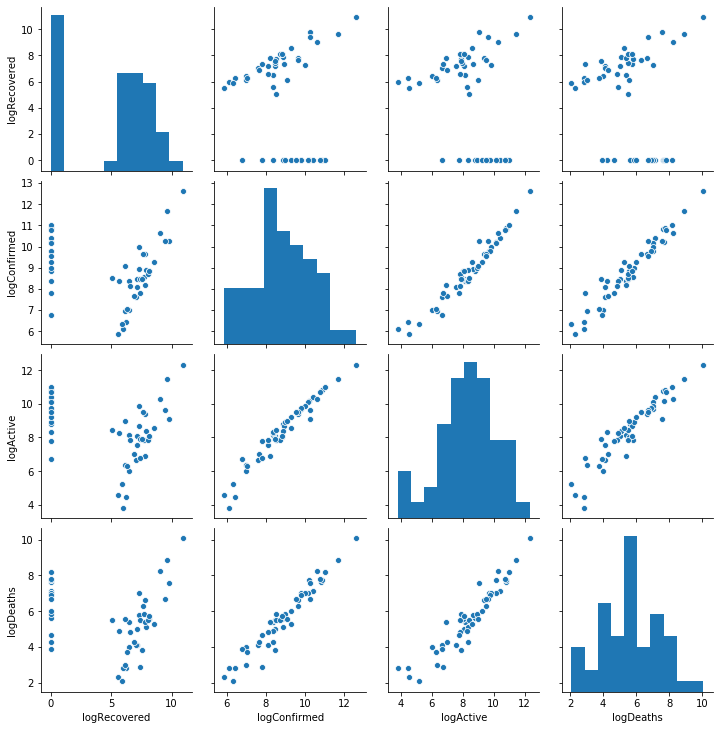

In [7]:
# Convert the total numbers of confirmed, dead, recovered, and active cases in each state into log-scale
USstates['logDeaths'] = USstates['Deaths'].agg(lambda x: np.log(x+1))
USstates['logRecovered'] = USstates['Recovered'].agg(lambda x: np.log(x+1))
USstates['logConfirmed'] = USstates['Confirmed'].agg(lambda x: np.log(x+1))
USstates['logActive'] = USstates['Active'].agg(lambda x: np.log(x+1))

sns.pairplot(vars = ['logRecovered','logConfirmed','logActive','logDeaths'], data = USstates);

In this section, we are interested in the relationships between the number of confirmed, dead, recovered and active cases. 
Surprisingly, we see all four variables are highly linear correlated with each other in log-scale. Thus, if we know the number 
of confirmed cases, we can possibly estimate the number of deaths by using this relationship. Another thing to note is that we observed 
a fair amount of states with recovered number being zero. Therefore, we print out the states with zero recovered. We know this information of states with zero recovered 
cases is not correct, i.e. California that already have recovered cases reported in the news. Thus, we attribute the zero recoveries to governments not actively tracking 
the cases.

In [8]:
USstates[USstates['Recovered']==0]

,Province_State,StateName,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,...,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,logDeaths,logRecovered,logConfirmed,logActive
0,Alabama,AL,US,5/1/2020 2:32,32.3182,-86.9023,7088,272,0,6816,...,978.0,3.837472,84000001,USA,1859.627115,13.797968,5.609472,0.0,8.866300,8.827175
4,California,CA,US,5/1/2020 2:32,36.1162,-119.6816,50130,2031,0,48099,...,NaN,4.051466,84000006,USA,1594.896734,NaN,7.616776,0.0,10.822395,10.781037
6,Connecticut,CT,US,5/1/2020 2:32,41.5978,-72.7554,27700,2257,0,25443,...,NaN,8.148014,84000009,USA,2724.409003,NaN,7.722235,0.0,10.229224,10.144235
9,Florida,FL,US,5/1/2020 2:32,27.7663,-81.6868,33690,1268,0,32422,...,5795.0,3.763728,84000012,USA,1801.027156,17.200950,7.145984,0.0,10.424986,10.386623
10,Georgia,GA,US,5/1/2020 2:32,33.0406,-83.6431,26264,1132,0,25132,...,5156.0,4.310082,84000013,USA,1469.949927,19.631435,7.032624,0.0,10.175993,10.131937
13,Illinois,IL,US,5/1/2020 2:32,40.3495,-88.9861,52918,2355,0,50563,...,NaN,4.450282,84000017,USA,2299.548223,NaN,7.764721,0.0,10.876518,10.830995
14,Indiana,IN,US,5/1/2020 2:32,39.8494,-86.2583,17835,1114,0,16721,...,NaN,6.246145,84000018,USA,1451.682260,NaN,7.016610,0.0,9.788974,9.724480
21,Massachusetts,MA,US,5/1/2020 2:32,42.2302,-71.5301,62205,3562,0,58643,...,5942.0,5.726228,84000025,USA,4015.969645,9.552287,8.178358,0.0,11.038207,10.979241
25,Missouri,MO,US,5/1/2020 2:32,38.4561,-92.2884,7818,350,0,7468,...,NaN,4.476848,84000029,USA,1377.039097,NaN,5.860786,0.0,8.964312,8.918516
27,Nebraska,NE,US,5/1/2020 2:32,41.1254,-98.2681,4281,70,0,4211,...,NaN,1.635132,84000031,USA,1660.097347,NaN,4.262680,0.0,8.362175,8.345693




#### In Part 3, we will further build features and examine in more detail what are the factors influencing the spread of the COVID-19 in different states.

## Part 3   
## Question1: What are the factors influencing how fast the COVID-19 spreads in different counties?


### 3.1 Feature building and selection

### Field Descriptions of the Counties Dataset

Here we list description of some of the important fields    
**Population Density:** population density per square mile in each county in 2010  
**Rural-urban code:** rural-urban continuum code in 2013  
**Population:** estimated total population of each county in 2018  
**Male Fraction:** fraction of male population to the total population in 2017   
**Smokers Percentage:** estimated percentage of adult smokers in each county (2017)  
**Dem to Rep ratio:** ratio of the number of votes received by the Democratic candidate over that received by the Republican candidate in the 2016 presidential election  
**65+ Percentage:** estimated population of 65+ age group in a county in 2017 normalized by 2018 estimate population of that county    
**Average Hospital #:** number of hospitals in the Hospital Compare general information file, of a county normalized by 2018 estimate population of that county     
**Average ICU beds:** number of ICU beds reported in the most recent cost report for each hospital, including the categories "intensive care unit," "coronary care unit," "burn intensive care unit" and "surgical intensive care unit," aggregated by county then normalized by 2018 population estimate  
**Avg Hospital FTE:** number of full-time employees at hospitals in 2017 normalized by 2018 estimate population 

For others please check https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/list_of_columns.md

### Further data cleaning and initial feature engineering.
Here, we do further data cleaning and initial feature engineering for the random forest model, which includes dropping features, filling missing data, normalize features and rename features for better understanding.  
**Drop 9 counties with missing population data.** This should be fine because our dataset have around 3000 counties.    
**Fill counties with missing date for certain orders with 0**: Because counties with missing order date values never applied those orders, we mark their date with 0.   
**Drop features that provide similar information**  eq. 'HPSAScore' is a score that is estimated from 'HPSAShortage', 'HPSAUnderservedPop', and 'HPSAServedPop'. Thus, we only keep 'HPSAScore' and drop the others.   
**Normalize features that have strong correlations** eq. we normalize 'PopulationEstimate65+2017' by ''PopulationEstimate2018'   
**Rename features for easier understanding** eq. rename 'FracMale2017' to 'Male Fraction'   



In [9]:
### Drop redundant features
to_drop = ['PopTotalMale2017', 'PopTotalFemale2017','CensusPopulation2010','STATEFP', 'COUNTYFP','POP_LATITUDE', 'POP_LONGITUDE', 
       'CensusRegionName','CensusDivisionName','3-YrMortalityAge<1Year2015-17','lat','lon','MedianAge2010','3-YrMortalityAge1-4Years2015-17',
       '3-YrMortalityAge5-14Years2015-17','3-YrMortalityAge15-24Years2015-17','3-YrMortalityAge25-34Years2015-17','3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge45-54Years2015-17','3-YrMortalityAge55-64Years2015-17','3-YrMortalityAge65-74Years2015-17','3-YrMortalityAge75-84Years2015-17', 
        'PopFmle15-192010','PopMale20-242010', 'PopFmle20-242010', 'PopFmle25-292010',
        'PopFmle30-342010', 'PopFmle35-442010', 'PopMale45-542010','StrokeMortality','HeartDiseaseMortality',
       'PopFmle45-542010',  'PopFmle55-592010','PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010','PopMale55-592010','PopFmle65-742010',
       'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010', 'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopMale>842010', 'PopFmle>842010','PopFmle10-142010', 'PopMale15-192010','PopMale25-292010','PopMale30-342010',
       'PopMale35-442010', 'PopFmle55-592010', 'PopFmle15-192010', 'PopMale65-742010', '3-YrMortalityAge25-34Years2015-17',
       'HPSAServedPop', 'HPSAUnderservedPop','PopMale20-242010', 'PopFmle20-242010',  '3-YrDiabetes2015-17', 'PopMale<52010','3-YrMortalityAge85+Years2015-17',
       'State',"TotalM.D.'s,TotNon-FedandFed2017",'CountyName', 'StateName','mortality2015-17Estimated',       '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '#HospParticipatinginNetwork2017','HPSAShortage']
counties["FIPS"]= counties["countyFIPS"].astype('float')
counties = counties.drop(columns = to_drop)

### Normalize features with strong correlation
to_normalize = [
       'PopulationEstimate65+2017', 
       '#Hospitals', '#ICU_beds','#FTEHospitalTotal2017']
counties["FIPS"]= counties["countyFIPS"].astype('float')
for c in to_normalize:
    counties[c+'normalized'] = counties[c]/ counties['PopulationEstimate2018']
orders = ['stay at home', '>50 gatherings','>500 gatherings', 
          'public schools', 'restaurant dine-in','entertainment/gym']
counties[orders] = counties[orders] -737494  
counties[orders] = counties[orders].fillna(0)
counties = counties.drop(columns = to_normalize)

### Rename features for easier understanding
features = {'Rural-UrbanContinuumCode2013': 'Rural-Urban Code', 'PopulationEstimate2018': 'Population',
       'FracMale2017':'Male Fraction', 'PopulationDensityperSqMile2010': 'Population Density', 
       'Smokers_Percentage': 'Smokers Percentage', 'dem_to_rep_ratio': 'Dem to Rep ratio',
       'PopulationEstimate65+2017normalized':'65+ Percentage',
       '#EligibleforMedicare2018normalized':'Eligible for Medicare percentage',
       '#Hospitalsnormalized': 'Average Hospital #',
       '#ICU_bedsnormalized': 'Average ICU beds',
       }
counties.rename(columns = features,inplace=True)

### Drop 9 counties with missing population data
counties = counties.dropna(subset=['Population'])

**The following block is a helper function for feature engineering**    
 We first label the data of different classes ([0,a) class 0, [a,b) class 1, [b, +inf) class 2), and then create the scatter plot of the distribution colored by their classes 

In [10]:
def makefeature(data, variable, a, b,ylim, cal = None, var = None):
    data['FIPS'] = timeConfirmed_org['FIPS']
    merge_data = data.merge(counties, left_on='FIPS', right_on="FIPS", how='inner')
    if cal:
        merge_data[var] = merge_data[variable]/merge_data[cal]
        merge_data = merge_data.drop(columns = [variable])
        variable = var
    merge_data['label'] = [0 if x < a else 1 if x < b else 2 for x in merge_data[variable]]
    merge_data = merge_data.fillna(0)
    fig = plt.figure()
    sns.scatterplot(x = merge_data.index, y = merge_data[variable],  s = 20, hue = merge_data['label'])
    plt.ylim(ylim)
    title = 'Distribution of ' + variable + ' over Different Counties'
    plt.title(title)
    plt.xlabel('Counties (ordered by FIPS number)')
    #fig.savefig(title + '.png',bbox_inches='tight')
    return  merge_data.drop(columns=['FIPS', 'countyFIPS', variable, 'label']), merge_data['label']

### 3.2 Model Building
Randomly split data into 80% training and 20% testing sets. Run the random forest model of 1000 decision trees with a maximum depth of 3.
Select the 10 most imporant features and use them in splitting. Then, plot the degree of feature importance as a function of these features.

In [11]:
### Random forest model
### Randomly split the data in 80% trianing set and 20% testing set
### Use a random forest model with 1000 trees and tree depth of 3
### Print the training and testing accuracy
### Plot the 10 most important features in the category
def randomforest(x, y, title):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    random_forest_model = ensemble.RandomForestClassifier(random_state = 44, n_estimators = 1000, max_depth = 3)
    random_forest_model.fit(x_train, y_train)
    training_accuracy = random_forest_model.score(x_train, y_train)
    test_accuracy = random_forest_model.score(x_test, y_test)
    print("training accuracy: " + str(training_accuracy))
    print("testing accuracy: " + str(test_accuracy))
    importance = random_forest_model.feature_importances_
    features = []
    aa = []
    bb = []
    for a,b in sorted(zip(-importance,X.columns)): 
        if a < 0:
            features.append(b)
            aa.append(-a)
            bb.append(b)
    fig = plt.figure()
    sns.barplot(x=bb[:10],y= aa[:10])
    plt.xticks(rotation=90)
    plt.ylabel('Importance')
    title = "Top 10 most important features when classifying " + title
    plt.title(title)
    plt.xlabel('Features')
    #fig.savefig(title + '.png',bbox_inches='tight')

### 3.3 Training and testing on different variables

**In this block, we run the model on GRC (Growth Rate of Confirmed Cases) and plot the results**    
We first calculate average GRC from 4/25/20 to 4/30/20 and then classify GRC into different classes (class 0: low GRC, class 1: moderate GRC, class 2: high GRC)  
In the end, we run the random forest model to select out top 10 most important features used in this classification.

training accuracy: 0.6946656050955414
testing accuracy: 0.7006369426751592


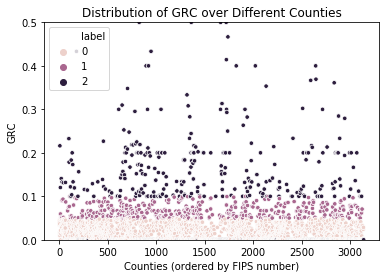

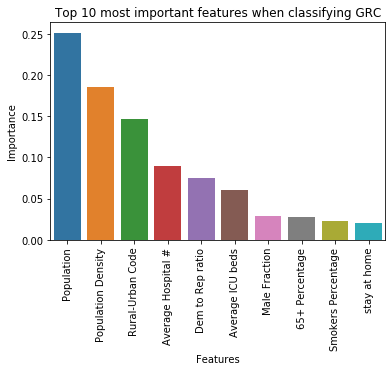

In [12]:
###Growth rate of confirmed cases
## some time series is not monotonic (probably due to inaccuracies in the report, only missing one ppl), we count it as slow increase
def growthrate(data):
    r,c = data.shape
    days = ['4/25/20', '4/26/20', '4/27/20', '4/28/20', '4/29/20', '4/30/20']
    tmp = [0 for _ in range(r)]
    for i in range(1, len(days)):
        tmp += (data[days[i]] - data[days[i-1]])/data[days[i-1]]
    return tmp/(len(days) - 1)
col = 'GRC'
growth_confirmed = pd.DataFrame(growthrate(timeConfirmed_org),columns = [col])
X, Y = makefeature(growth_confirmed, col, 0.05, 0.1, [0,0.5])
randomforest(X,Y, col)

**Description of the results:**   
We first print out the training and testing accuracies of the classification, which are both above 69%, showing the model validity.     
We then plot GRC over different counties. Counties are ordered by their FIPS. Dots are colored by their GRC classes.  
In the end we show the plot of 10 most important features used in the GRC classification. **Top factors include: population, population density and rural-urban code suggesting the disease spreads faster in denser regions with higher urbanization.** 

**In this block, we run the model on GRD (Growth Rate of Dead Cases) and plot out the results**    
We first calculate average GRD over 4/25/20 to 4/30/20 period, and then classify GRD into different classes (class 0: low GRD, class 1: moderate GRD, class 2: high GRD).
In the end, we run the random forest classifier and plot out the results.

training accuracy: 0.6954617834394905
testing accuracy: 0.7022292993630573


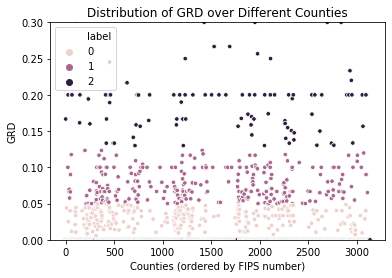

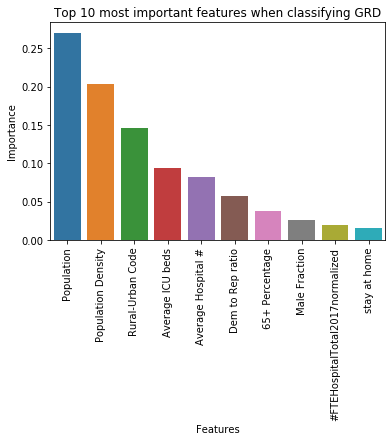

In [13]:
###Growth rate of dead cases
col = 'GRD'
growth_dead = pd.DataFrame(growthrate(timeDeath_org),columns = [col])
X, Y = makefeature(growth_dead, col, 0.05, 0.13, [0,0.3])
randomforest(X,Y, col)

**Description of the results:**   
We first print out the training and testing accuracies of the classification, which are both above 69%, showing the model validity.     
We then plot GRD over different counties, colored by their classes. Counties are ordered by their FIPS.   
In the end, we plot 10 most important features used in the GRD classification. **Similar results to GRC, except different important level of "average ICU beds".**

**In this block, we run the model on incidence rate and plot out the results**    
Here, we calculate incidence rate on 4/30/20 and then classify it into different classes (class 0: low incidence rate, class 1: moderate incidence rate, class 2: high incidence rate)  In the end, we run the random forest classifier.

training accuracy: 0.8746019108280255
testing accuracy: 0.8805732484076433


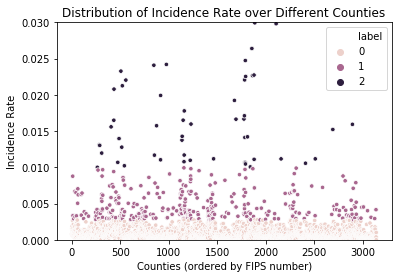

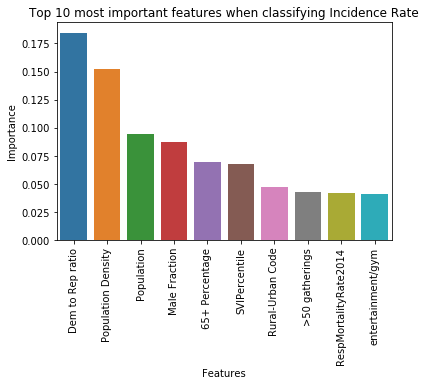

In [14]:
###Incidence Rate
tmp= 'confirmed'
col = 'Incidence Rate'
incident = pd.DataFrame(np.array(timeConfirmed_org['4/30/20']), columns = [tmp])
X, Y = makefeature(incident, tmp, 0.00275, 0.01,[0,0.03], 'Population', col)
randomforest(X,Y, col)


**Description of the results:**   
We first print out the training and testing accuracies of the classification, which are both above 87%, showing the model validity.     
We then plot incidence rates of different counties, colored by their classes. Counties are ordered by their FIPS.   
In the end, we plot 10 most important features used in the classification of the incidence rates. 
**Interestingly, dem-to-rep ratio and population density are the top two factors.**

**In the block, we plot incidence rate over dem-to-rep ratio and population density**    
The plot clearly shows counties with higher dem-to-rep ratio tend to have higher incidence rate.

Text(0, 0.5, 'log(Population Density + 1)')

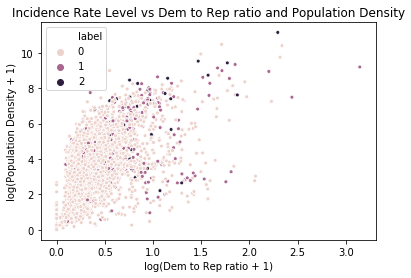

In [15]:
### Incidence rate level as a function of two most important factors
fig = plt.figure()
sns.scatterplot(np.log(X[features['dem_to_rep_ratio']] +1) ,np.log(X[features['PopulationDensityperSqMile2010']]+1), hue = Y,s = 15)
title = "Incidence Rate Level vs "+ features['dem_to_rep_ratio'] + " and " + features['PopulationDensityperSqMile2010']
plt.title(title);
plt.xlabel('log(' +features['dem_to_rep_ratio'] +  ' + 1)')
plt.ylabel('log(' + features['PopulationDensityperSqMile2010'] + ' + 1)')

#fig.savefig(title + ".png")


**In the block we run the model on mortality rate**    
We first calculate mortality rate on 4/30/20 and classify it into different classes (class 0: low mortality rate, class 1: moderate mortality rate, class 2: high mortality rate)  
In the end, we run the random forest model.

training accuracy: 0.767515923566879
testing accuracy: 0.7579617834394905


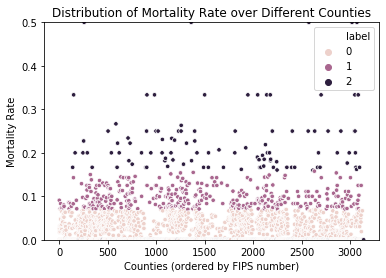

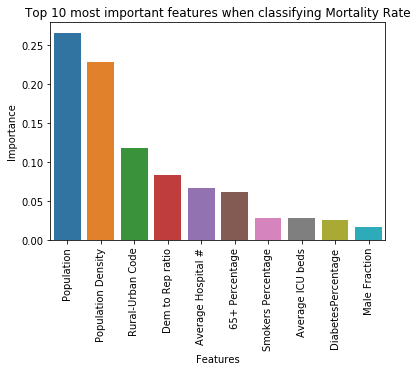

In [16]:
###Mortality Rate
col = "Mortality Rate"
mortality = pd.DataFrame(np.array(timeDeath_org['4/30/20']/timeConfirmed_org['4/30/20']), columns = [col])
X, Y = makefeature(mortality, col, 0.07,0.16,[0,0.5])
randomforest(X,Y, col)

**Description of the results:**   
Here we print out the training and testing accuracies, which are both above 75%, showing the validity of the model. 
And then we plot mortality rate over different counties, colored by their classes. Counties are ordered by their FIPS.   
In the end, we plot 10 most important features used in the classification of mortality rate. **Similar results to GRC and GRD, except for slight difference in the feature importance of the average hospital numbers and percentage of people over 65 years old.**

## Part 4  
## Question2: Can we predict the confirmed and death cases in the US and NY using the historical trend of confirmed and death time series?
 

## 4.1 Prediction of the number of the confirmed cases in the US
### 4.1.1 Building features for the US data

In [17]:
# Slice the dataframe, only keep time series data after the 1st confirmed cases in US
# us_cases: confirmed case timeseries in the US
# us_deaths: death timeseries in the US

us_cases = timeConfirmed.loc[:,'1/22/20':'5/7/20'].sum()
us_deaths = timeDeath.loc[:,'1/22/20':'5/7/20'].sum()

# Scale the data into total number of cases per 100k
us_cases_100k = us_cases/100000.0
us_deaths_100k = us_deaths/100000.0

In [18]:
# function to create features, which relate to the date since federal/state orders were issued. 
# Set dates before the first date that an order is issued as zero, and the date that order is issued as 1, the following day is 2, etc.
def get_column_order(order_date, ts_date):   
    col=np.zeros(len(ts_date),)
    for k in range(0,len(ts_date)):
        if ts_date[k] <= order_date:
            col[k]=0
        else:
            col[k]=ts_date[k] - order_date
    return col

In [19]:
# Build feature matrix, all features includes:
# first_case: # of days after the first confirmed cases in the US

ts_start_date = pd.Timestamp.toordinal(datetime.strptime('2020-01-22', '%Y-%m-%d').date())

feature_US = pd.DataFrame(columns = ["us_cases"])
feature_US['us_cases'] = us_cases
feature_US['first_case'] = np.arange(0,len(us_cases)) 
feature_US['federal_guideline'] = get_column_order(Counties['federal guidelines'][0].astype(int)-ts_start_date, 
                                                   feature_US['first_case'])
feature_US['travel_ban'] = get_column_order(Counties['foreign travel ban'][0].astype(int)-ts_start_date, 
                                                   feature_US['first_case'])

In [20]:
feature_US.head()

,us_cases,first_case,federal_guideline,travel_ban
1/22/20,1,0,0.0,0.0
1/23/20,1,1,0.0,0.0
1/24/20,2,2,0.0,0.0
1/25/20,2,3,0.0,0.0
1/26/20,5,4,0.0,0.0


### 4.1.2 Feature selection

In [21]:
# Split the data into training and test sets, use the last 7 days as the test set
# Never touch the test dataset before obtaining the final model

X_train = feature_US.iloc[:-7,:];  X_test = feature_US.iloc[-7:,:]
y_train_confirmed = np.array(us_cases_100k[:-7]).reshape(-1,1)
y_train_death = np.array(us_deaths_100k[:-7]).reshape(-1,1)

y_test_confirmed = np.array(us_cases_100k[-7:]).reshape(-1,1)
y_test_death = np.array(us_deaths_100k[-7:]).reshape(-1,1)

In [22]:
# List all combinations of features
feature_list = [ 'first_case', 'federal_guideline', 'travel_ban', 
                ['first_case', 'federal_guideline'], ['federal_guideline', 'travel_ban'], 
                ['first_case',  'travel_ban'], ['first_case', 'federal_guideline', 'travel_ban']]


rmse = []
pvalues = [] 
rsquared = []
for i in range(len(feature_list)):

    model = LinearRegression(normalize=True, fit_intercept=True)
    X0 = X_train[feature_list[i]]
    # fix single feature issue
    if i<3:
        X0=np.array(X0).reshape(-1,1)
        
    model.fit(X0,y_train_confirmed)
    y_hat = model.predict(X0)
    rmse.append(np.sqrt(mean_squared_error(y_train_confirmed,y_hat)))
    # for p-values calculation
    sm_model = sm.OLS(y_train_confirmed, X0).fit()
    pvalues.append(list(np.round(sm_model.pvalues,5)))
    rsquared.append(np.round(sm_model.rsquared,5))
    

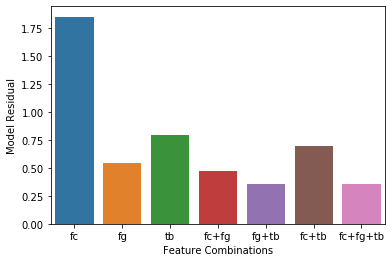

In [23]:
# Plotting all models and residuals
plt.figure()
sns.barplot(x=['fc', 'fg', 'tb', 'fc+fg', 'fg+tb', 'fc+tb', 'fc+fg+tb'], y=rmse)
plt.ylabel('Model Residual')
plt.xlabel('Feature Combinations');

In [24]:
# Add the p-value portion
# Print out the stats in a table

stats = pd.DataFrame(rmse)
stats['index']=['fc', 'fg', 'tb', 'fc+fg', 'fg+tb', 'fc+tb', 'fc+fg+tb']
stats['p_values']=pvalues
stats['R_squared']=rsquared
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)

print(stats)
print('\n')
print('Taking RMSE, p_values and R_squared into consideration, our preffered features are: fg+tb')

              RMSE             p_values  R_squared
index                                             
fc        1.853794                [0.0]    0.65511
fg        0.540639                [0.0]    0.97697
tb        0.796915                [0.0]    0.94920
fc+fg     0.475970           [0.0, 0.0]    0.98321
fg+tb     0.357970           [0.0, 0.0]    0.99110
fc+tb     0.699558           [0.0, 0.0]    0.96378
fc+fg+tb  0.357136  [0.48524, 0.0, 0.0]    0.99115


Taking RMSE, p_values and R_squared into consideration, our preffered features are: fg+tb


#### In this section, we tested our models with the combinations of different features listed above. Taking RMSE, p_values, and R_squared factors into consideration, our preferred subset of features are days after the federal guidelines and travel ban order were first announced (fg+tb).

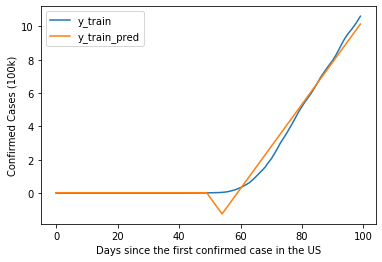

In [25]:
# Plot the actual confirmed cases (y_train) and the predicted ones (y_train_pred)
model = LinearRegression(normalize=True, fit_intercept=True)
X0 = X_train[['federal_guideline', 'travel_ban']]
model.fit(X0,y_train_confirmed)
y_train_pred = model.predict(X0)

plt.figure(figsize=(6,4))
plt.plot(X_train['first_case'],y_train_confirmed)
plt.plot(X_train['first_case'],y_train_pred)
plt.legend(['y_train','y_train_pred'])
plt.xlabel('Days since the first confirmed case in the US')
plt.ylabel('Confirmed Cases (100k)')
plt.show()

### 4.1.3 Polynomial feature transformation 

Even though the linear regression model performs fairly well. We would like to further transform our preferred subset of features 
into higher degree polynomial forms and improve the fitting.

In [26]:
# In this case, the preferred subset of features are 'federal_guideline' & 'travel_ban'

rmse = []
pvalues = [] 
rsquared = []
# Transform features
for degree in range(1,6):

    poly = PolynomialFeatures(degree=degree)
    # X0 is the feature subset we selected earlier
    # X0_ matrix after polynomial transformation
    X0_ = poly.fit_transform(X0)

    model = LinearRegression(normalize=True, fit_intercept=True)
    model.fit(X0_, y_train_confirmed)
    y_hat = model.predict(X0_)
    rmse.append(np.sqrt(mean_squared_error(y_train_confirmed,y_hat)))
    # for p-values calculation
    sm_model = sm.OLS(y_train_confirmed, X0_).fit()
    #pvalues.append(list(np.round(sm_model.pvalues,5)))
    rsquared.append(np.round(sm_model.rsquared,5))

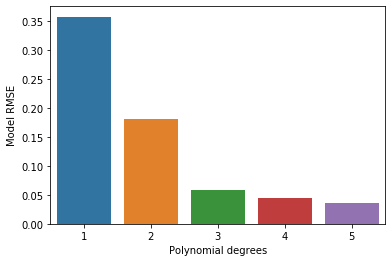

In [27]:
# Plotting all models and residuals
plt.figure(figsize=(6,4))
sns.barplot(x=np.arange(1,6), y=rmse)
plt.ylabel('Model RMSE')
plt.xlabel('Polynomial degrees');

In [28]:
# Print out statistics
stats = pd.DataFrame(rmse)
stats['index']=np.arange(1,6)
#stats['p_values']=pvalues
stats['R_squared']=rsquared
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)

print(stats)

           RMSE  R_squared
index                     
1      0.357970    0.98757
2      0.181325    0.99681
3      0.057769    0.99968
4      0.044172    0.99981
5      0.036760    0.99987


According to the plot above, the model residual is reduced by ~50% when we transformed the features to degree-2 polynomial. 
However, the model RMSE does not change much when the polynomial degree is higher than 3. To keep the model simpler and 
avoid overfitting, we use degree equal to 3 as our final model for the US confirmed dataset.

### 4.1.4 Model result

In [29]:
# The RMSE do not reduce much after polynomial degree > 3
# To keep the model simpler, we use the 3rd-degree model as our final model and try it with the testing dataset 

X0 = X_train[['federal_guideline', 'travel_ban']]
Xt0 = X_test[['federal_guideline', 'travel_ban']]

poly = PolynomialFeatures(degree=3)
X0_ = poly.fit_transform(X0)
Xt0_ = poly.fit_transform(Xt0)

model = LinearRegression(normalize=True, fit_intercept=True)
model.fit(X0_, y_train_confirmed)
y_train_pred = model.predict(X0_)
y_test_pred = model.predict(Xt0_)
print('Training rmse: ',np.sqrt(mean_squared_error(y_train_confirmed,y_train_pred)))
print('Test rmse: ',np.sqrt(mean_squared_error(y_test_confirmed,y_test_pred)))

Training rmse:  0.057769279135535895
Test rmse:  0.5941650859832724


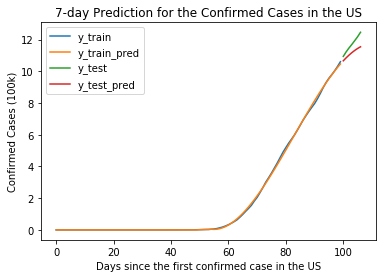

In [30]:
# Plot the training and testing datasets
plt.figure(figsize=(6,4))
plt.plot(X_train['first_case'],y_train_confirmed)
plt.plot(X_train['first_case'],y_train_pred)
plt.plot(X_test['first_case'],y_test_confirmed)
plt.plot(X_test['first_case'],y_test_pred)
plt.legend(['y_train','y_train_pred','y_test','y_test_pred'])
plt.xlabel('Days since the first confirmed case in the US')
plt.ylabel('Confirmed Cases (100k)')
plt.title('7-day Prediction for the Confirmed Cases in the US')

plt.show()

#### According to the previous plot, the training and testing RMSEs are 0.057 and 0.594, respectively. Our prediction underestimates the data, indicating the limitation of the linear regression model. 


## 4.2 Prediction for the number of dead cases in the US
### 4.2.1 Feature selection

In [31]:
# List all combinations of features
feature_list = ['us_cases', 'first_case', 'federal_guideline', 'travel_ban', 
               ['us_cases', 'first_case'], ['us_cases', 'federal_guideline'],
               ['us_cases', 'travel_ban'], ['first_case', 'federal_guideline'], 
               ['federal_guideline', 'travel_ban'], ['first_case',  'travel_ban'], 
               ['us_cases','federal_guideline', 'travel_ban'],
               ['us_cases','first_case','travel_ban'],
               ['us_cases','first_case', 'federal_guideline'],
               ['first_case', 'federal_guideline', 'travel_ban'],
               ['us_cases','first_case', 'federal_guideline', 'travel_ban']]


rmse = []
pvalues = [] 
rsquared = []
for i in range(len(feature_list)):

    model = LinearRegression(normalize=True, fit_intercept=True)
    X0 = X_train[feature_list[i]]
    # fix single feature issue
    if i<4:
        X0=np.array(X0).reshape(-1,1)
        
    model.fit(X0,y_train_death)
    y_hat = model.predict(X0)
    rmse.append(np.sqrt(mean_squared_error(y_train_death,y_hat)))
    # for p-values calculation
    sm_model = sm.OLS(y_train_death, X0).fit()
    pvalues.append(list(np.round(sm_model.pvalues,5)))
    rsquared.append(np.round(sm_model.rsquared,5))

In [32]:
# Print statistics
stats = pd.DataFrame(rmse)
stats['index']=['cc', 'fc', 'fg', 'tb', 'cc+fc', 'cc+fg', 'cc+tb', 'fc+fg', 'fg+tb', 'fc+tb', 
                'cc+fg+tb','cc+fc+tb','cc+fc+fg','fc+fg+tb','cc+fc+fg+tb']
stats['p_values']=pvalues
stats['R_squared']=rsquared
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)

print(stats)
print('\n')
print('Taking RMSE, p_values and R_squared into consideration, our preffered features are: cc+fg+tb')

                 RMSE                      p_values  R_squared
index                                                         
cc           0.021056                         [0.0]    0.98835
fc           0.113841                         [0.0]    0.59301
fg           0.049212                         [0.0]    0.93754
tb           0.062055                         [0.0]    0.89980
cc+fc        0.017994                    [0.0, 0.0]    0.99182
cc+fg        0.010757                    [0.0, 0.0]    0.99732
cc+tb        0.012725                    [0.0, 0.0]    0.99622
fc+fg        0.044165                    [0.0, 0.0]    0.95243
fg+tb        0.035384                    [0.0, 0.0]    0.97111
fc+tb        0.055805                    [0.0, 0.0]    0.92434
cc+fg+tb     0.010414           [0.0, 0.0, 0.00963]    0.99750
cc+fc+tb     0.012530           [0.0, 0.06353, 0.0]    0.99635
cc+fc+fg     0.010688           [0.0, 0.24551, 0.0]    0.99736
fc+fg+tb     0.035328           [0.56884, 0.0, 0.0]    

#### Similar to 4.1, we perform linear regression on all combinations of features, then use the RMSEs, p_values and R_squareds to identify our preferred subset of features. Note that in the death prediction, we also include the confirmed case time series as a candidate feature. Our preferred subset of features are confirmed cases, numbers of days after the federal guidelines and travel ban order were first announced (cc+fg+tb).  

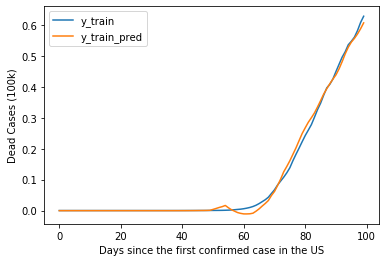

In [33]:
# Plot the fittings for our selected model
model = LinearRegression(normalize=True, fit_intercept=True)
X0 = X_train[['us_cases','federal_guideline', 'travel_ban']]
model.fit(X0,y_train_death)
y_train_pred = model.predict(X0)

plt.figure(figsize=(6,4))
plt.plot(X_train['first_case'],y_train_death)
plt.plot(X_train['first_case'],y_train_pred)
plt.legend(['y_train','y_train_pred'])
plt.xlabel('Days since the first confirmed case in the US')
plt.ylabel('Dead Cases (100k)')
plt.show()

### 4.2.2 Polynomial feature transformation 

Use our preferred subset of features, and transform them to polynomial forms

In [34]:
# In this case, the preferred subset of features are: 'us_cases' & federal_guideline' & 'travel_ban'
# Plot the fittings for our selected model
model = LinearRegression(normalize=True, fit_intercept=True)
X0 = X_train[['us_cases','federal_guideline', 'travel_ban']]
model.fit(X0,y_train_death)
y_train_pred = model.predict(X0)


rmse = []
pvalues = [] 
rsquared = []
# Transform features
for degree in range(1,6):

    poly = PolynomialFeatures(degree=degree)
    # X0 is the feature subset we selected earlier
    # X0_ matrix after polynomial transformation
    X0_ = poly.fit_transform(X0)

    model = LinearRegression(normalize=True, fit_intercept=True)
    model.fit(X0_, y_train_death)
    y_hat = model.predict(X0_)
    rmse.append(np.sqrt(mean_squared_error(y_train_death,y_hat)))
    # for rmse calculation
    sm_model = sm.OLS(y_train_death, X0_).fit()
    rsquared.append(np.round(sm_model.rsquared,5))

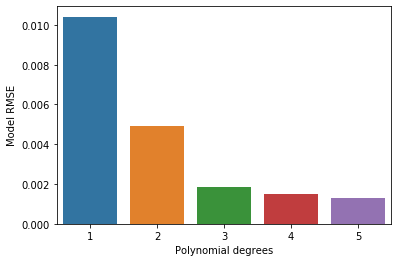

In [35]:
# Plotting all models and residuals
plt.figure(figsize=(6,4))
sns.barplot(x=np.arange(1,6), y=rmse)
plt.ylabel('Model RMSE')
plt.xlabel('Polynomial degrees');

In [36]:
# Print out statistics
stats = pd.DataFrame(rmse)
stats['index']=np.arange(1,6)
stats['R_squared']=rsquared
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)

print(stats)

           RMSE  R_squared
index                     
1      0.010414    0.99667
2      0.004942    0.99925
3      0.001870    0.99986
4      0.001501    0.99959
5      0.001308    0.99716


According to the previous plot, the model residual is reduced by ~50% when we transformed the features to degree-2 polynomial. 
However, the model RMSE does not change much when polynomial degree is higher than 3. To keep the model simpler and 
avoid overfitting, we use degree equal to 3 as our final model for the US dead cases.

### 4.2.3 Model result

In [37]:
# The RMSE does not reduce much after polynomial degree > 3
# To keep the model simpler, we use the 3rd-degree model as our final model and try it with the testing dataset. 

X0 = X_train[['us_cases','federal_guideline', 'travel_ban']]
Xt0 = X_test[['us_cases','federal_guideline', 'travel_ban']]

poly = PolynomialFeatures(degree=3)
X0_ = poly.fit_transform(X0)
Xt0_ = poly.fit_transform(Xt0)

model = LinearRegression(normalize=True, fit_intercept=True)
model.fit(X0_, y_train_death)
y_train_pred = model.predict(X0_)
y_test_pred = model.predict(Xt0_)
print('Training rmse: ',np.sqrt(mean_squared_error(y_train_death,y_train_pred)))
print('Test rmse: ',np.sqrt(mean_squared_error(y_test_death,y_test_pred)))

Training rmse:  0.0018695044742988477
Test rmse:  0.01696410309378022


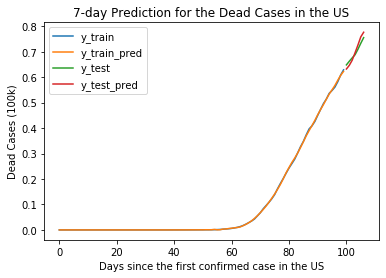

In [38]:
# Plot the training and testing datasets
plt.figure(figsize=(6,4))
plt.plot(X_train['first_case'],y_train_death)
plt.plot(X_train['first_case'],y_train_pred)
plt.plot(X_test['first_case'],y_test_death)
plt.plot(X_test['first_case'],y_test_pred)
plt.legend(['y_train','y_train_pred','y_test','y_test_pred'])
plt.xlabel('Days since the first confirmed case in the US')
plt.ylabel('Dead Cases (100k)')
plt.title('7-day Prediction for the Dead Cases in the US')
plt.show()

#### According to plot above, the training and testing RMSEs are 0.00186 and 0.01696, respectively.

## 4.3 Prediction for the number of confirmed cases in NY

Since some other features, e.g. the numbers of days after the stay-at-home and no restaurant dine-in orders were first enforced, are different for different states, these state-wise 
orders are not applicable when we generate the model for the entire country. Therefore, in this section, we select New York, 
currently the COVID-19 hotspot in the US as an example showing how other features could also be beneficial for the state forecasting
model. 

### 4.3.1 Building features for NY data

In [39]:
# Only count the numbers in NY state
ny_cases = timeConfirmed[timeConfirmed["Province_State"]=='New York'].sum().loc['1/22/20':'5/7/20']
ny_deaths = timeDeath[timeDeath["Province_State"]=='New York'].sum().loc['1/22/20':'5/7/20']

# Scale the data into total number of cases per 100k
ny_cases_100k = ny_cases/100000.0
ny_deaths_100k = ny_deaths/100000.0

# Examine the order released date 
#the numbers (#number) represent the numbers of days that a particular order was enforced after the first case was confirmed in the US
#print(Counties['foreign travel ban'][0].astype(int)-ts_start_date) #49
#print(Counties['>500 gatherings'][0].astype(int)-ts_start_date) #51
#print(Counties['federal guidelines'][0].astype(int)-ts_start_date)  #54
#print(Counties['public schools'][0].astype(int)-ts_start_date)  #54
#print(Counties['restaurant dine-in'][0].astype(int)-ts_start_date) #57
#print(Counties['>50 gatherings'][0].astype(int)-ts_start_date) #58
#print(Counties['entertainment/gym'][0].astype(int)-ts_start_date) #66
#print(Counties['stay at home'][0].astype(int)-ts_start_date) #73


# Given several orders are released more or less the same time 
# e.g. travel ban & >500 gatherings, federal_guidelines & public schools, resuatrant dine-in & >50 gatherings
# We will only include only one for each pair

# build up all feature columns
feature_NY = pd.DataFrame(columns = ["ny_cases"])
feature_NY['ny_cases'] = ny_cases
feature_NY['first_case'] = np.arange(0,len(ny_cases)) 
feature_NY['federal_guideline'] = get_column_order(Counties['federal guidelines'][0].astype(int)-ts_start_date, 
                                                   feature_NY['first_case'])
feature_NY['travel_ban'] = get_column_order(Counties['foreign travel ban'][0].astype(int)-ts_start_date, 
                                                   feature_NY['first_case'])
feature_NY['stay_home'] = get_column_order(Counties['stay at home'][0].astype(int)-ts_start_date, 
                                                   feature_NY['first_case'])
feature_NY['entertainment_gym'] = get_column_order(Counties['entertainment/gym'][0].astype(int)-ts_start_date, 
                                                   feature_NY['first_case'])
feature_NY['restaurant_dine-in'] = get_column_order(Counties['restaurant dine-in'][0].astype(int)-ts_start_date, 
                                                   feature_NY['first_case'])

# Compared to feature_US, added more time-related orders
# If a county never release such order, will fill it to 0
feature_NY = feature_NY.fillna(0) 
feature_NY.head()

,ny_cases,first_case,federal_guideline,travel_ban,stay_home,entertainment_gym,restaurant_dine-in
1/22/20,0,0,0.0,0.0,0.0,0.0,0.0
1/23/20,0,1,0.0,0.0,0.0,0.0,0.0
1/24/20,0,2,0.0,0.0,0.0,0.0,0.0
1/25/20,0,3,0.0,0.0,0.0,0.0,0.0
1/26/20,0,4,0.0,0.0,0.0,0.0,0.0


### 4.3.2 Feature selection

In [40]:
# Split the data into training and test sets, use the last 7 days of the time series as the test set
# Never touch the test data set before obtaining the final model

X_train = feature_NY.iloc[:-7,:];  X_test = feature_NY.iloc[-7:,:]
y_train_confirmed = np.array(ny_cases_100k[:-7]).reshape(-1,1)
y_train_death = np.array(ny_deaths_100k[:-7]).reshape(-1,1)

y_test_confirmed = np.array(ny_cases_100k[-7:]).reshape(-1,1)
y_test_death = np.array(ny_deaths_100k[-7:]).reshape(-1,1)

In [41]:
# List all combinations of features
# We have the features in US part as the defaults. Then add other features, and consider the p-value, RMSE and R-squared
feature_list = [['federal_guideline', 'travel_ban'],
                ['federal_guideline', 'travel_ban', 'stay_home'],
                ['federal_guideline', 'travel_ban', 'entertainment_gym'],
                ['federal_guideline', 'travel_ban', 'restaurant_dine-in'],
                ['federal_guideline', 'travel_ban', 'stay_home', 'entertainment_gym'],
                ['federal_guideline', 'travel_ban', 'stay_home', 'restaurant_dine-in'],
                ['federal_guideline', 'travel_ban', 'entertainment_gym', 'restaurant_dine-in'],
                ['federal_guideline', 'travel_ban', 'stay_home', 'entertainment_gym', 'restaurant_dine-in']]

feature_list_short = ['fg+tb','fg+tb+sh','fg+tb+eg','fg+tb+rd',
                      'fg+tb+sh+eg','fg+tb+sh+rd','fg+tb+eg+rd','fg+tb+sh+eg+rd']

rmse = []
pvalues = [] 
rsquared = []
for i in range(len(feature_list)):

    model = LinearRegression(normalize=True, fit_intercept=True)
    X0 = X_train[feature_list[i]]
    
    model.fit(X0,y_train_confirmed)
    y_hat = model.predict(X0)
    rmse.append(np.sqrt(mean_squared_error(y_train_confirmed,y_hat)))
    # for p-values calculation
    sm_model = sm.OLS(y_train_confirmed.astype(int), X0).fit()
    pvalues.append(list(np.round(sm_model.pvalues,5)))
    rsquared.append(np.round(sm_model.rsquared,5))

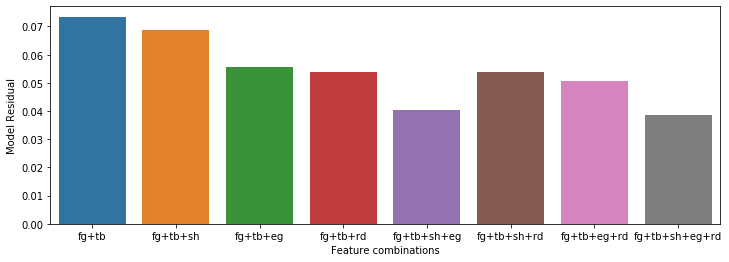

In [42]:
# Plot residuals
plt.figure(figsize=(12,4))
ax = sns.barplot(x=feature_list_short, y=rmse)
plt.ylabel('Model Residual')
plt.xlabel('Feature combinations');

In [43]:
# Add the p-value portion
# Print out the stats in a table

stats = pd.DataFrame(rmse)
stats['index']=feature_list_short
stats['p_values']=pvalues
stats['R_squared']=rsquared
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)

print(stats)
print('\n')
print('Taking RMSE, p_values and R_squared into consideration, our preferred features are: fg+tb+sh')

                    RMSE                                 p_values  R_squared
index                                                                       
fg+tb           0.073463                               [0.0, 0.0]    0.94361
fg+tb+sh        0.068692                 [3e-05, 0.00303, 0.0016]    0.94914
fg+tb+eg        0.055508                  [0.50935, 0.70326, 0.0]    0.95890
fg+tb+rd        0.053966                [0.03907, 0.64793, 5e-05]    0.95238
fg+tb+sh+eg     0.040532           [0.30523, 0.53118, 5e-05, 0.0]    0.96545
fg+tb+sh+rd     0.053961     [0.12893, 0.72295, 0.19669, 0.00479]    0.95321
fg+tb+eg+rd     0.050739      [0.83868, 0.9603, 0.00016, 0.65221]    0.95899
fg+tb+sh+eg+rd  0.038770  [0.70737, 0.92618, 4e-05, 0.0, 0.42324]    0.96568


Taking RMSE, p_values and R_squared into consideration, our preferred features are: fg+tb+sh


#### Similar to previous sections, we perform linear regression on all combinations of features, then use the RMSEs, p_values and R_squareds to select the subset of features. Our preferred subset of features are the numbers of days after stay at home, federal guidelines and travel ban order were announced (sh+fg+tb).  

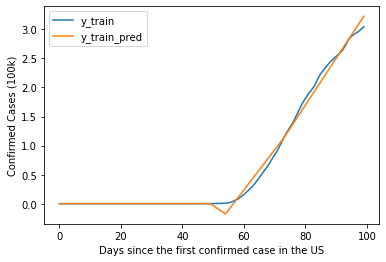

In [44]:
# Plot the fittings for our selected model
model = LinearRegression(normalize=True, fit_intercept=True)
X0 = X_train[['federal_guideline', 'travel_ban','stay_home']]
model.fit(X0,y_train_confirmed)
y_train_pred = model.predict(X0)

plt.figure(figsize=(6,4))
plt.plot(X_train['first_case'],y_train_confirmed)
plt.plot(X_train['first_case'],y_train_pred)
plt.legend(['y_train','y_train_pred'])
plt.xlabel('Days since the first confirmed case in the US')
plt.ylabel('Confirmed Cases (100k)')
plt.show()

### 4.3.3 Polynomial feature transformation

In [45]:
# In this case, the preferred subset of features are 'federal_guideline' & 'travel_ban' & 'stay_home'
# Build polynomial model

rmse = []
pvalues = [] 
rsquared = []
# Transform features
for degree in range(1,6):

    poly = PolynomialFeatures(degree=degree)
    # X0 is the feature subset we selected earlier
    # X0_ matrix after polynomial transformation
    X0_ = poly.fit_transform(X0)

    model = LinearRegression(normalize=True, fit_intercept=True)
    model.fit(X0_, y_train_confirmed)
    y_hat = model.predict(X0_)
    rmse.append(np.sqrt(mean_squared_error(y_train_confirmed,y_hat)))
    # for p-values calculation
    sm_model = sm.OLS(y_train_confirmed.astype(int), X0_).fit()
    pvalues.append(list(np.round(sm_model.pvalues,5)))
    rsquared.append(np.round(sm_model.rsquared,5))

           RMSE  R_squared
index                     
1      0.068692    0.93203
2      0.011190    0.95623
3      0.010597    0.96121
4      0.010388    0.97968
5      0.009105    0.98285


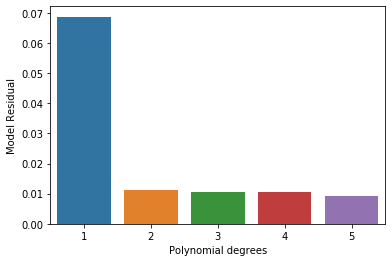

In [46]:
# Print out statistics
stats = pd.DataFrame(rmse)
stats['index']=np.arange(1,6)
#stats['p_values']=pvalues
stats['R_squared']=rsquared
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)
print(stats)

# Plotting all models and residuals
plt.figure(figsize=(6,4))
sns.barplot(x=np.arange(1,6), y=rmse)
plt.ylabel('Model Residual')
plt.xlabel('Polynomial degrees');
plt.show()

According to the plot above, the model residual is significantly reduced when we transformed the features to degree-2 polynomial. 
However, the model RMSE does not change much when polynomial degree is higher than 2. To keep the model simpler and 
avoid overfitting, we use degree equal to 2 as our final model.

### 4.3.3 Model result

Training rmse:  0.011189629743865935
Test rmse:  0.0165790653276714


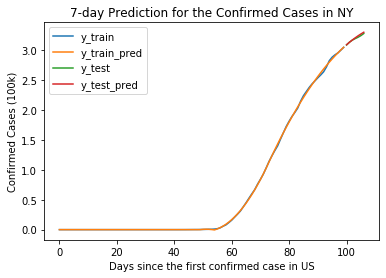

In [47]:
# The RMSE does not reduce much after polynomial degree > 2
# To keep the model simpler, we use the 2nd-degree model as our final model and apply it with the test dataset. 

X0 = X_train[['federal_guideline', 'travel_ban', 'stay_home']]
Xt0 = X_test[['federal_guideline', 'travel_ban','stay_home']]

poly = PolynomialFeatures(degree=2)
X0_ = poly.fit_transform(X0)
Xt0_ = poly.fit_transform(Xt0)

model = LinearRegression(normalize=True, fit_intercept=True)
model.fit(X0_, y_train_confirmed)
y_train_pred = model.predict(X0_)
y_test_pred = model.predict(Xt0_)
print('Training rmse: ',np.sqrt(mean_squared_error(y_train_confirmed,y_train_pred)))
print('Test rmse: ',np.sqrt(mean_squared_error(y_test_confirmed,y_test_pred)))

# Plot the training data and test data
plt.figure(figsize=(6,4))
plt.plot(X_train['first_case'],y_train_confirmed)
plt.plot(X_train['first_case'],y_train_pred)
plt.plot(X_test['first_case'],y_test_confirmed)
plt.plot(X_test['first_case'],y_test_pred)
plt.legend(['y_train','y_train_pred','y_test','y_test_pred'])
plt.xlabel('Days since the first confirmed case in US')
plt.ylabel('Confirmed Cases (100k)')
plt.title('7-day Prediction for the Confirmed Cases in NY')
plt.show()

## 4.4 Prediction for the number of dead cases in NY

### 4.4.1 Feature selection

In [48]:
# List all combinations of features
# We have the features in US death part as the defaults. Then add other features, and consider the p-value, RMSE and R-squared
feature_list = [['ny_cases', 'federal_guideline', 'travel_ban'],
                ['ny_cases', 'federal_guideline', 'travel_ban', 'stay_home'],
                ['ny_cases','federal_guideline', 'travel_ban', 'entertainment_gym'],
                ['ny_cases','federal_guideline', 'travel_ban', 'restaurant_dine-in'],
                ['ny_cases','federal_guideline', 'travel_ban', 'stay_home', 'entertainment_gym'],
                ['ny_cases','federal_guideline', 'travel_ban', 'stay_home', 'restaurant_dine-in'],
                ['ny_cases','federal_guideline', 'travel_ban', 'entertainment_gym', 'restaurant_dine-in'],
                ['ny_cases','federal_guideline', 'travel_ban', 'stay_home', 'entertainment_gym', 'restaurant_dine-in']]

feature_list_short = ['cc+fg+tb','cc+fg+tb+sh','cc+fg+tb+eg','cc+fg+tb+rd',
                      'cc+fg+tb+sh+eg','cc+fg+tb+sh+rd','cc+fg+tb+eg+rd','cc+fg+tb+sh+eg+rd']

rmse = []
pvalues = [] 
rsquared = []
for i in range(len(feature_list)):

    model = LinearRegression(normalize=True, fit_intercept=True)
    X0 = X_train[feature_list[i]]   
    model.fit(X0,y_train_death)
    y_hat = model.predict(X0)
    rmse.append(np.sqrt(mean_squared_error(y_train_death,y_hat)))
    # for p-values calculation
    sm_model = sm.OLS(y_train_death.astype(float), X0).fit()
    pvalues.append(list(np.round(sm_model.pvalues,5)))
    rsquared.append(np.round(sm_model.rsquared,5))

In [49]:
# Print statistics
stats = pd.DataFrame(rmse)
stats['index']=feature_list_short
stats['R_squared']=rsquared
stats['p_values']=pvalues
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)
print(stats)

                       RMSE  R_squared  \
index                                    
cc+fg+tb           0.005023    0.99690   
cc+fg+tb+sh        0.001813    0.99960   
cc+fg+tb+eg        0.002486    0.99924   
cc+fg+tb+rd        0.004920    0.99703   
cc+fg+tb+sh+eg     0.001811    0.99960   
cc+fg+tb+sh+rd     0.001439    0.99975   
cc+fg+tb+eg+rd     0.002199    0.99941   
cc+fg+tb+sh+eg+rd  0.001430    0.99975   

                                                     p_values  
index                                                          
cc+fg+tb                              [0.0, 0.00015, 0.17023]  
cc+fg+tb+sh                            [0.0, 0.0, 4e-05, 0.0]  
cc+fg+tb+eg                          [0.0, 0.0, 0.00159, 0.0]  
cc+fg+tb+rd                   [0.0, 0.00029, 0.6611, 0.04749]  
cc+fg+tb+sh+eg                [0.0, 0.0, 6e-05, 0.0, 0.71068]  
cc+fg+tb+sh+rd              [0.0, 0.16187, 0.29442, 0.0, 0.0]  
cc+fg+tb+eg+rd                [0.0, 0.80435, 0.483, 0.0, 0.0]  
cc+

#### Surprisingly, the p_values for travel ban feature of all models are larger than 0.05, which suggests no/less correlation between the dead cases in NY. Therefore, we take out 'tb' and perform the feature selection again.

In [50]:
# Given the p-values for tb are all high
# Try combinations of features without tb

# List all combination of features
# We have the features in US death part as the defaults. Then add other features, and consider the p-value, RMSE and R-squared
feature_list = [['ny_cases', 'federal_guideline'],
                ['ny_cases', 'federal_guideline', 'stay_home'],
                ['ny_cases','federal_guideline','entertainment_gym'],
                ['ny_cases','federal_guideline','restaurant_dine-in'],
                ['ny_cases','federal_guideline','stay_home', 'entertainment_gym'],
                ['ny_cases','federal_guideline','stay_home', 'restaurant_dine-in'],
                ['ny_cases','federal_guideline','entertainment_gym', 'restaurant_dine-in'],
                ['ny_cases','federal_guideline','stay_home', 'entertainment_gym', 'restaurant_dine-in']]

feature_list_short = ['cc+fg','cc+fg+sh','cc+fg+eg','cc+fg+rd',
                      'cc+fg+sh+eg','cc+fg+sh+rd','cc+fg+eg+rd','cc+fg+sh+eg+rd']

rmse = []
pvalues = [] 
rsquared = []
for i in range(len(feature_list)):

    model = LinearRegression(normalize=True, fit_intercept=True)
    X0 = X_train[feature_list[i]]   
    model.fit(X0,y_train_death)
    y_hat = model.predict(X0)
    rmse.append(np.sqrt(mean_squared_error(y_train_death,y_hat)))
    # for p-values calculation
    sm_model = sm.OLS(y_train_death.astype(float), X0).fit()
    pvalues.append(list(np.round(sm_model.pvalues,5)))
    rsquared.append(np.round(sm_model.rsquared,5))

# Print statistics
stats = pd.DataFrame(rmse)
stats['index']=feature_list_short
stats['R_squared']=rsquared
stats['p_values']=pvalues
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)
print(stats)
print('\n')
print('Taking RMSE, p_values and R_squared into consideration, our preffered features are: cc+fg+sh+rd')

                    RMSE  R_squared                         p_values
index                                                               
cc+fg           0.005066    0.99684                       [0.0, 0.0]
cc+fg+sh        0.001970    0.99952                  [0.0, 0.0, 0.0]
cc+fg+eg        0.002610    0.99916                  [0.0, 0.0, 0.0]
cc+fg+rd        0.004926    0.99702               [0.0, 0.0, 0.0174]
cc+fg+sh+eg     0.001962    0.99952         [0.0, 0.0, 0.0, 0.36499]
cc+fg+sh+rd     0.001446    0.99974             [0.0, 0.0, 0.0, 0.0]
cc+fg+eg+rd     0.002204    0.99940         [0.0, 0.37942, 0.0, 0.0]
cc+fg+sh+eg+rd  0.001438    0.99975  [0.0, 2e-05, 0.0, 0.29104, 0.0]


Taking RMSE, p_values and R_squared into consideration, our preffered features are: cc+fg+sh+rd


#### Similar to previous sections, we perform linear regression on all combinations of features, then use the RMSEs, p_values and R_squareds to select the features. Our preferred subset of features are the NY confirmed cases, the numbers of days after the federal guidelines,stay at home, and dine-in restaurant closure orders were announced (cc+fg+sh+rd).  

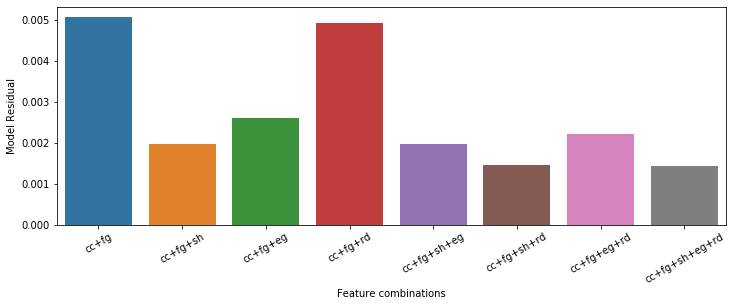

In [51]:
# Plot residuals
plt.figure(figsize=(12,4))
ax = sns.barplot(x=feature_list_short, y=rmse)
plt.ylabel('Model Residual')
plt.xlabel('Feature combinations')
plt.xticks(rotation=30);

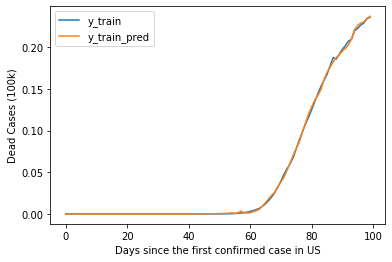

In [52]:
# Plot the fittings for our selected model
model = LinearRegression(normalize=True, fit_intercept=True)
X0 = X_train[['ny_cases','federal_guideline','stay_home', 'restaurant_dine-in']]
model.fit(X0,y_train_death)
y_train_pred = model.predict(X0)

plt.figure(figsize=(6,4))
plt.plot(X_train['first_case'],y_train_death)
plt.plot(X_train['first_case'],y_train_pred)
plt.legend(['y_train','y_train_pred'])
plt.xlabel('Days since the first confirmed case in US')
plt.ylabel('Dead Cases (100k)')
plt.show()

### 4.4.2 Polynomial feature transformation

In [53]:
# In this case, the preferred subset of features are 'NY confirmed cases' & 'federal_guideline' & 'stay_home' & 'restaurant_dine-in'
# Build polynomial model

rmse = []
pvalues = [] 
rsquared = []
# Transform features
for degree in range(1,6):

    poly = PolynomialFeatures(degree=degree)
    # X0 is the feature subset we selected earlier
    # X0_ matrix after polynomial transformation
    X0_ = poly.fit_transform(X0)

    model = LinearRegression(normalize=True, fit_intercept=True)
    model.fit(X0_, y_train_death)
    y_hat = model.predict(X0_)
    rmse.append(np.sqrt(mean_squared_error(y_train_death,y_hat)))
    # for p-values calculation
    sm_model = sm.OLS(y_train_confirmed.astype(int), X0_).fit()
    pvalues.append(list(np.round(sm_model.pvalues,5)))
    rsquared.append(np.round(sm_model.rsquared,5))

           RMSE  R_squared
index                     
1      0.001446    0.95542
2      0.000966    0.97503
3      0.000756    0.98040
4      0.000568    0.98100
5      0.000479    0.98118


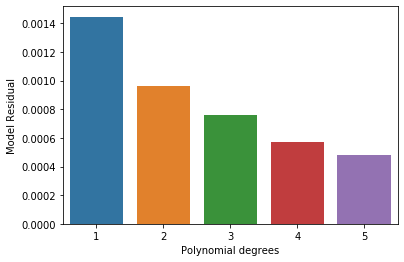

In [54]:
# Print out statistics
stats = pd.DataFrame(rmse)
stats['index']=np.arange(1,6)
#stats['p_values']=pvalues
stats['R_squared']=rsquared
stats.rename({0:'RMSE'},axis='columns', inplace=True)
stats.set_index('index', inplace=True)
print(stats)

# Plotting all models and residuals
plt.figure(figsize=(6,4))
sns.barplot(x=np.arange(1,6), y=rmse)
plt.ylabel('Model Residual')
plt.xlabel('Polynomial degrees');
plt.show()

According to the previous plot, the model residual is significantly reduced when we transformed the features to degree-2 polynomial. 
However, the model RMSE does not change much when polynomial degree is higher than 2. To keep the model simpler and 
avoid oferfitting, we use degree equal to 2 as our final model.

### 4.4.3 Model result

Training rmse:  0.0009655501488465292
Test rmse:  0.006513089989410395


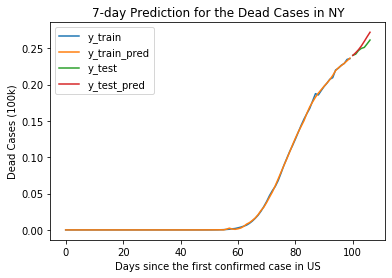

In [55]:
# Given the RMSE do not reduce much after polynomial degree > 2
# To keep the model simpler, we use the 2nd-degree model as our final model and apply it with the test dataset. 

X0 = X_train[['ny_cases','federal_guideline','stay_home', 'restaurant_dine-in']]
Xt0 = X_test[['ny_cases','federal_guideline','stay_home', 'restaurant_dine-in']]

poly = PolynomialFeatures(degree=2)
X0_ = poly.fit_transform(X0)
Xt0_ = poly.fit_transform(Xt0)

model = LinearRegression(normalize=True, fit_intercept=True)
model.fit(X0_, y_train_death)
y_train_pred = model.predict(X0_)
y_test_pred = model.predict(Xt0_)
print('Training rmse: ',np.sqrt(mean_squared_error(y_train_death,y_train_pred)))
print('Test rmse: ',np.sqrt(mean_squared_error(y_test_death,y_test_pred)))

# Plot the training data and test data
plt.figure(figsize=(6,4))
plt.plot(X_train['first_case'],y_train_death)
plt.plot(X_train['first_case'],y_train_pred)
plt.plot(X_test['first_case'],y_test_death)
plt.plot(X_test['first_case'],y_test_pred)
plt.legend(['y_train','y_train_pred','y_test','y_test_pred'])
plt.xlabel('Days since the first confirmed case in US')
plt.ylabel('Dead Cases (100k)')
plt.title('7-day Prediction for the Dead Cases in NY')
plt.show()


## END OF NOTEBOOK
## THANKS FOR READING :)